In [1]:
import numpy as np

# Load X data
X_train = np.load('X_train_filtered.npy')
y_train = np.load('y_train_filtered.npy')

# Convert time duration to minutes
y_train *= 60

# Bin the training data
y_train_binned = (y_train // 6).astype(int)
y_train_binned[np.where(y_train_binned >= 10)[0]] = 10  # 1+ hours (because people leave these on the chargers)

print(X_train.shape)
print(y_train_binned.shape)

(533855, 3953)
(533855,)


In [2]:
# Get the testing data
X_test = np.load('X_test_filtered.npy')
y_test = np.load('y_test_filtered.npy')

# Convert hours to minutes
y_test *= 60

# Bin the testing data
y_test_binned = (y_test // 6).astype(int)
y_test_binned[np.where(y_test_binned >= 10)[0]] = 10

print(X_test.shape)
print(y_test.shape)

(135844, 3953)
(135844,)


<Axes: ylabel='Density'>

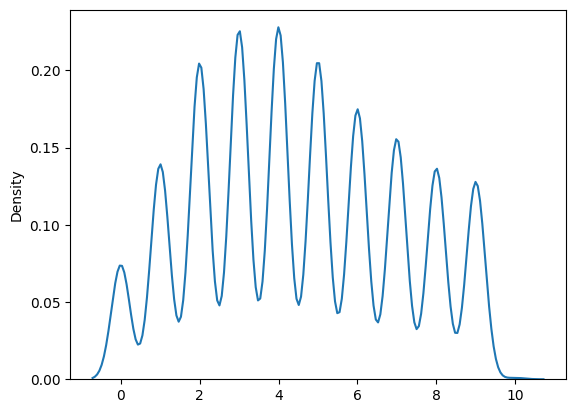

In [3]:
import seaborn as sns

sns.kdeplot(y_test_binned)

In [4]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def score_model(model, X_test, y_test):
    '''Score model'''

    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds, average='macro')
    pre = precision_score(y_test, preds, average='macro')
    f1 =  f1_score(y_test, preds, average='macro')
    
    print(f'Accuracy:  {acc:.2%}')
    print(f'Recall:    {rec:.2%}')
    print(f'Precision: {pre:.2%}')
    print(f'F1 score:  {f1:.2%}')

    return acc, rec, pre, f1

In [5]:
# Declare data
classifiers = {}
scores = {}

In [6]:
from sklearn.dummy import DummyClassifier

# Most frequent
clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, y_train_binned)
classifiers['MostFrequent'] = clf

# Score
scores['Most Frequency'] = score_model(clf, X_test, y_test_binned)

Accuracy:  13.61%
Recall:    9.09%
Precision: 1.24%
F1 score:  2.18%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


As expected, the accuracy is 81.80%. This is because 81.80% of the test data is in the first bin which is the class that is **always** being predicted. 

In [7]:
# Random classifier
clf = DummyClassifier(strategy="uniform", random_state=42)
clf.fit(X_train, y_train_binned)
classifiers['Uniform'] = clf

# Score
scores['Uniform'] = score_model(clf, X_test, y_test_binned)

Accuracy:  8.98%
Recall:    8.55%
Precision: 8.97%
F1 score:  8.37%


Accuracy of 11% is expected as the is 1/9. There are 9 categories and it is uniformly picking a category. 

In [20]:
from sklearn.svm import LinearSVC

n = np.arange(200)
clf = LinearSVC(random_state=42, max_iter=10)
clf.fit(X_train, y_train_binned)
classifiers['LinearSVC'] = clf
scores['LinearSVC'] = score_model(clf, X_test, y_test_binned)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy:  16.82%
Recall:    14.36%
Precision: 15.63%
F1 score:  14.01%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=42, max_iter=10)
clf.fit(X_train, y_train_binned)
classifiers['LinearSVC'] = clf
scores['LinearSVC'] = score_model(clf, X_test, y_test_binned)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy:  16.82%
Recall:    14.36%
Precision: 15.63%
F1 score:  14.01%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
from sklearn.ensemble import VotingClassifier

# Tryout ensemble learning
estimators = []

# Train 200 classifiers
N = X_train.shape[0] // 200
for i in range(1, N):
    n = np.arange(200 * i, 200 * (i + 1))
    clf = LinearSVC()
    clf.fit(X_train[n,:], y_train_binned[n])
    estimators.append((f'LinearSVC_{i+1}', clf))

# Create the ensemble
ensemble = VotingClassifier(
    estimators = estimators, 
    voting = 'hard'
)

# Fit
ensemble.fit(X_train[:200,:], y_train_binned[:200])

scores['ensemble'] = score_model(ensemble, X_test, y_test_binned)

KeyboardInterrupt: 

In [19]:
from sklearn.svm import SVC

n = np.arange(200)
clf = SVC()
clf.fit(X_train[n,:], y_train_binned[n])
classifiers['SGCClassifier'] = clf

# Score
scores['SVCClassifier'] = score_model(clf, X_test, y_test_binned)

Accuracy:  12.63%
Recall:    9.24%
Precision: 5.21%
F1 score:  3.65%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
from sklearn.ensemble import VotingClassifier

# Tryout ensemble learning
estimators = []

# Train 200 classifiers
N = 50
for i in range(N):
    n = np.arange(100 * i, 100 * (i + 1))
    clf = LinearSVC()
    clf.fit(X_train[n,:], y_train_binned[n])
    estimators.append((f'LinearSVC_{i+1}', clf))

# Create the ensemble
ensemble = VotingClassifier(
    estimators = estimators, 
    voting = 'hard'
)

# Fit
ensemble.fit(X_train[:N * 100,:], y_train_binned[:N * 100])

scores['ensemble'] = score_model(ensemble, X_test, y_test_binned)

Accuracy:  9.34%
Recall:    9.93%
Precision: 9.76%
F1 score:  7.46%


A simple Linear Support Vector Machine already does a really good job. It maintains a 82.19% accuracy is is slightly better than the most frequent class. With how small this difference is, it is possible that is isn't even significant. However, The F1 score is 20% which is twice that of the most frequent predictor. 

In [18]:
from sklearn.neighbors import KNeighborsClassifier

n = np.arange(10000)
n_neighbors = 3
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf.fit(X_train[n,:], y_train_binned[n])
classifiers[f'KNN{n_neighbors}'] = clf

# Score
scores[f'KNN{n_neighbors}'] = score_model(clf, X_test, y_test_binned)

Accuracy:  11.74%
Recall:    9.42%
Precision: 9.43%
F1 score:  8.62%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
n = np.arange(10000)
n_neighbors = 4
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf.fit(X_train[n,:], y_train_binned[n])
classifiers[f'KNN{n_neighbors}'] = clf

# Score
scores[f'KNN{n_neighbors}'] = score_model(clf, X_test, y_test_binned)

Accuracy:  11.59%
Recall:    9.48%
Precision: 9.49%
F1 score:  8.98%


In [14]:
n = np.arange(10000)
n_neighbors = 5
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf.fit(X_train[n,:], y_train_binned[n])
classifiers[f'KNN{n_neighbors}'] = clf

# Score
scores[f'KNN{n_neighbors}'] = score_model(clf, X_test, y_test_binned)

Accuracy:  82.31%
Recall:    17.30%
Precision: 30.46%
F1 score:  18.60%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=42)
clf.fit(X_train, y_train)
classifiers['SGBClassifier'] = clf

# Score
scores['SGDClassifier'] = score_model(clf, X_test, y_test)

Accuracy:  82.35%
Recall:    20.66%
Precision: 24.43%
F1 score:  20.45%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import tensorflow as tf


clf = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

clf.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

clf.fit(X_train, y_train_binned, epochs=5, batch_size=128, validation_data=(X_test, y_test_binned))
classifiers['sequential'] = clf

Epoch 1/5
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 118s 28ms/step - accuracy: 0.1614 - loss: 2.1977 - val_accuracy: 0.1815 - val_loss: 2.1537
Epoch 2/5
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 117s 28ms/step - accuracy: 0.1932 - loss: 2.1260 - val_accuracy: 0.1869 - val_loss: 2.1410
Epoch 3/5
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 114s 27ms/step - accuracy: 0.2140 - loss: 2.0828 - val_accuracy: 0.1865 - val_loss: 2.1439
Epoch 4/5
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 118s 28ms/step - accuracy: 0.2375 - loss: 2.0310 - val_accuracy: 0.1850 - val_loss: 2.1653
Epoch 5/5
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 117s 28ms/step - accuracy: 0.2639 - loss: 1.9686 - val_accuracy: 0.1818 - val_loss: 2.1952


NameError: name 'classifiers' is not defined

In [ ]:
from sklearn.decomposition import PCA

# Build PCA model
pca = PCA(n_components=0.95).fit(X_train)

# Transform X data
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [87]:
preds = np.argmax(clf(X_test), axis=1)

acc = accuracy_score(y_test, preds)
rec = recall_score(y_test, preds, average='macro')
pre = precision_score(y_test, preds, average='macro')
f1 =  f1_score(y_test, preds, average='macro')

print(f'Accuracy:  {acc:.2%}')
print(f'Recall:    {rec:.2%}')
print(f'Precision: {pre:.2%}')
print(f'F1 score:  {f1:.2%}')

Accuracy:  82.74%
Recall:    15.10%
Precision: 19.32%
F1 score:  15.62%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_grid, n_iter=10, cv=3, verbose=1, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", rf_search.best_params_)

# Best model
best_rf_model = rf_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


In [96]:
param_grid = {
    'n_estimators': [150, 175, 200, 225, 250],
    'min_samples_split': [4, 5, 6, 7]
}

rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1), param_distributions=param_grid, n_iter=10, cv=3, verbose=1, n_jobs=-1)
rf_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", rf_search.best_params_)

# Best model
best_rf_model = rf_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 250, 'min_samples_split': 7}


In [99]:
# Create RandomForestClassifier
clf = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, n_estimators=250, min_samples_split=7)
clf.fit(X_train, y_train)
classifiers['RandomForest'] = clf 

# Score it
classifiers['RandomForest'] = score_model(clf, X_test, y_test)

Accuracy:  83.24%
Recall:    15.35%
Precision: 22.77%
F1 score:  15.70%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
from sklearn.decomposition import PCA

# Build PCA model
pca = PCA(n_components=0.95).fit(X_train)

# Transform X data
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [59]:
clf = tf.keras.Sequential([
    tf.keras.layers.Dense(2048, activation='relu', input_shape=(X_train_reduced.shape[1],)),    
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9)
])

clf.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

clf.fit(X_train_reduced, y_train, epochs=3, batch_size=32, validation_data=(X_test_reduced, y_test))

Epoch 1/3


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.7987 - loss: 0.6902 - val_accuracy: 0.8212 - val_loss: 0.5949
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.8193 - loss: 0.5574 - val_accuracy: 0.8332 - val_loss: 0.5682
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.8303 - loss: 0.4941 - val_accuracy: 0.8351 - val_loss: 0.5978


In [60]:
preds = np.argmax(clf(X_test_reduced), axis=1)

acc = accuracy_score(y_test, preds)
rec = recall_score(y_test, preds, average='macro')
pre = precision_score(y_test, preds, average='macro')
f1 =  f1_score(y_test, preds, average='macro')

print(f'Accuracy:  {acc:.2%}')
print(f'Recall:    {rec:.2%}')
print(f'Precision: {pre:.2%}')
print(f'F1 score:  {f1:.2%}')

Accuracy:  83.51%
Recall:    18.25%
Precision: 25.81%
F1 score:  18.93%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [102]:
for classifier in classifiers.keys():
    print(classifier)

MostFrequent
Uniform
LinearSVC
LinearSVC100_0
LinearSVC100_1
LinearSVC100_2
LinearSVC100_3
LinearSVC100_4
LinearSVC100_5
LinearSVC100_6
LinearSVC100_7
LinearSVC100_8
LinearSVC100_9
LinearSVC100_10
LinearSVC100_11
LinearSVC100_12
LinearSVC100_13
LinearSVC100_14
LinearSVC100_15
LinearSVC100_16
LinearSVC100_17
LinearSVC100_18
LinearSVC100_19
LinearSVC100_20
LinearSVC100_21
LinearSVC100_22
LinearSVC100_23
LinearSVC100_24
LinearSVC100_25
LinearSVC100_26
LinearSVC100_27
LinearSVC100_28
LinearSVC100_29
LinearSVC100_30
LinearSVC100_31
LinearSVC100_32
LinearSVC100_33
LinearSVC100_34
LinearSVC100_35
LinearSVC100_36
LinearSVC100_37
LinearSVC100_38
LinearSVC100_39
LinearSVC100_40
LinearSVC100_41
LinearSVC100_42
LinearSVC100_43
LinearSVC100_44
LinearSVC100_45
LinearSVC100_46
LinearSVC100_47
LinearSVC100_48
LinearSVC100_49
LinearSVC100_50
LinearSVC100_51
LinearSVC100_52
LinearSVC100_53
LinearSVC100_54
LinearSVC100_55
LinearSVC100_56
LinearSVC100_57
LinearSVC100_58
LinearSVC100_59
LinearSVC100_60
Lin

In [103]:
# Get the estimators to use in ensemble 

estimators = [
    ('LinearSVC', classifiers['LinearSVC']),
    ('KNN5', classifiers['KNN5']),
    ('SGBClassifier', classifiers['SGBClassifier']), 
    ('RandomForest', classifiers['RandomForest'])
]

# Create a hard voting ensemble classifier
ensemble = VotingClassifier(
    estimators = estimators,
    voting='hard'
)

# Fit 
ensemble.fit(X_train, y_train)

# Score
scores['ensemble'] = score_model(ensemble, X_test, y_test)

ValueError: The estimator tuple should be a classifier.